Plot saved as q1_plot.png


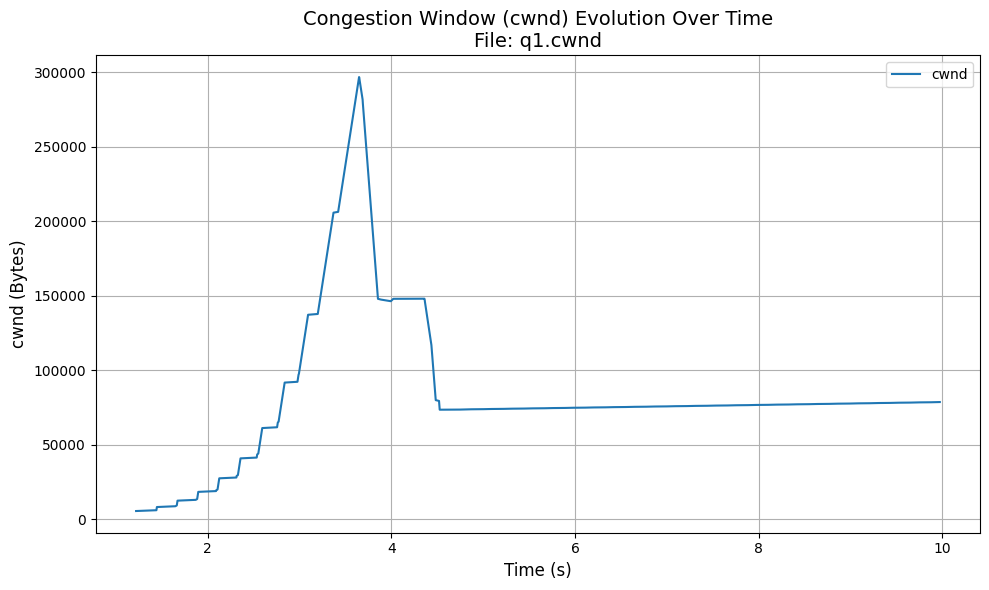

Plot saved as Q2_plot.png


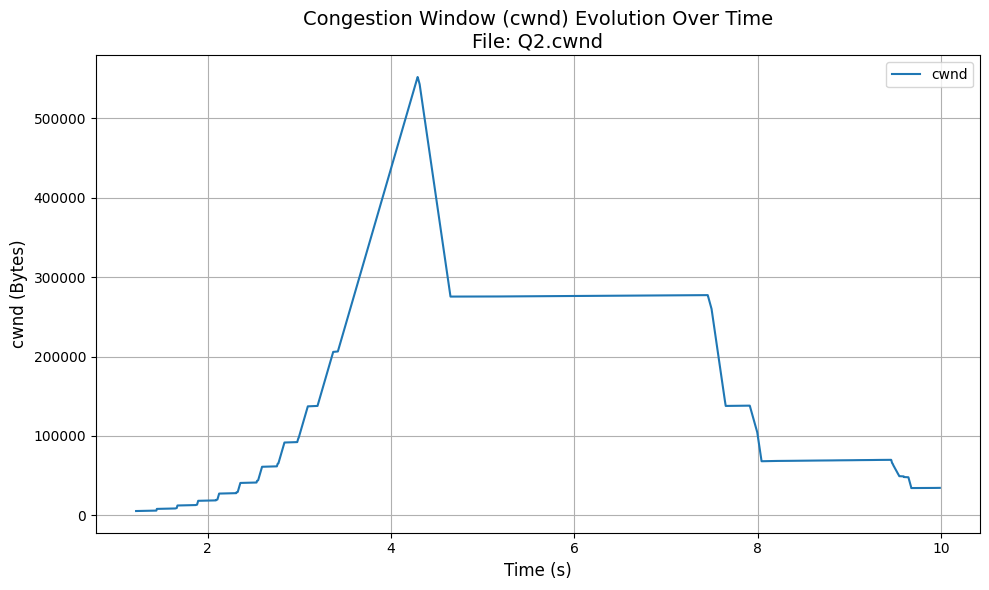

Plot saved as Q3_plot.png


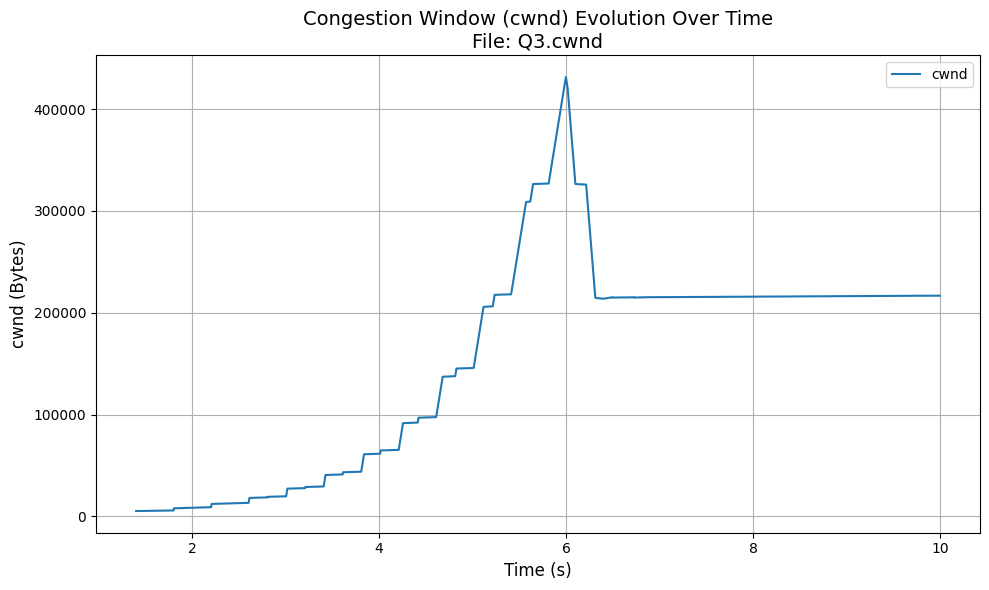

In [ ]:
import matplotlib.pyplot as plt
file_names = ["q1.cwnd", "Q2.cwnd", "Q3.cwnd"]
for file_name in file_names:
    time, old_cwnd, new_cwnd = [], [], []
    with open(file_name, "r") as file:
        for line in file:
            if line.strip():  # Ignore empty lines
                values = line.split()
                time.append(float(values[0]))
                old_cwnd.append(int(values[1]))
                new_cwnd.append(int(values[2]))

    plt.figure(figsize=(10, 6))
    plt.plot(time, new_cwnd, label="cwnd",  linestyle="-")
    plt.title(f"Congestion Window (cwnd) Evolution Over Time\nFile: {file_name}", fontsize=14)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("cwnd (Bytes)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    output_plot_name = file_name.replace(".cwnd", "_plot.png")
    plt.savefig(output_plot_name) 
    print(f"Plot saved as {output_plot_name}")
    plt.show()  


In [ ]:
# List of input files
input_files = ["q1tshark.txt", "q2tshark.txt", "q3tshark.txt"]

for i, file_name in enumerate(input_files):
    total_bytes = 0
    start_time = None
    end_time = None
    with open(file_name, "r") as f:
        for line in f:
            parts = line.split()
            if len(parts) == 2:  
                time = float(parts[0])
                length = int(parts[1])
                total_bytes += length
                if start_time is None:
                    start_time = time
                end_time = time
    simulation_time = end_time - start_time if end_time and start_time else 1  
    average_throughput = (total_bytes * 8) / (simulation_time * 10**6)  
    print(f"Average throughput for {file_name} is {average_throughput:.2f} Mbps")



File 1 (q1tshark.txt): Average Throughput = 2.80 Mbps
File 2 (q2tshark.txt): Average Throughput = 4.15 Mbps
File 3 (q3tshark.txt): Average Throughput = 2.97 Mbps


Total queueing delays collected: 18574
Total queueing delays collected: 27825
Total queueing delays collected: 19243


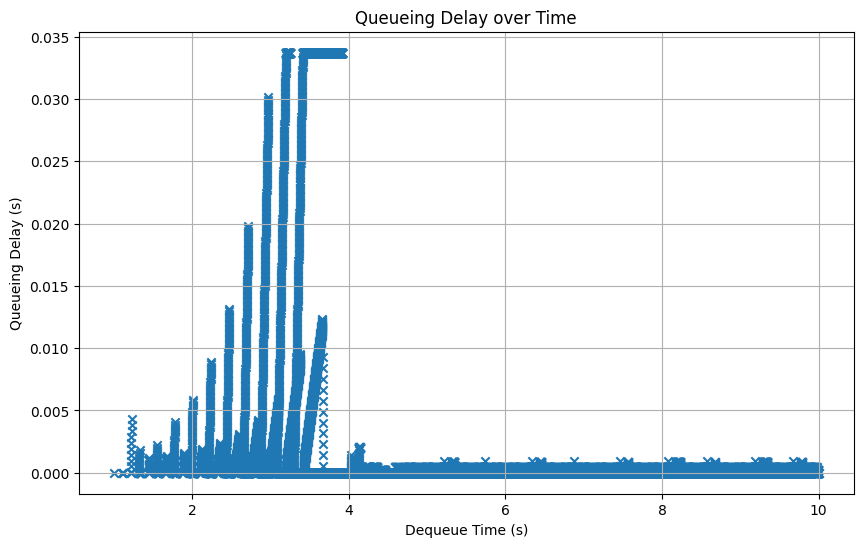

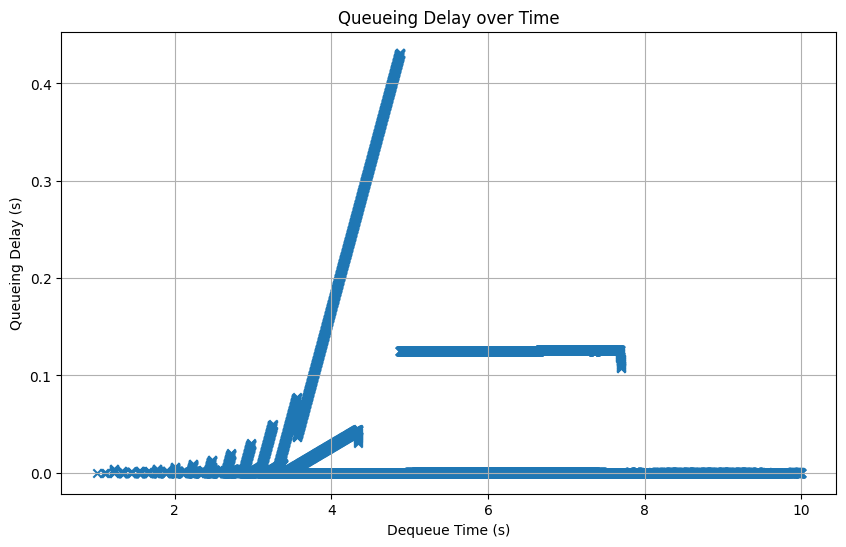

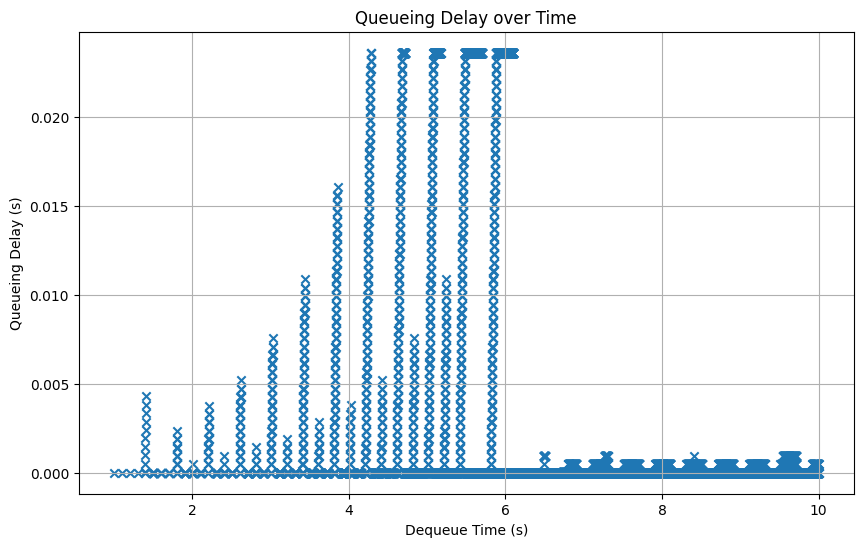

In [ ]:
import matplotlib.pyplot as plt
import sys
import re

def extract_tcp_fields(line):
    tcp_header_pattern = r'ns3::TcpHeader\s*\(\s*(\d+)\s*>\s*(\d+).*Seq=(\d+)'
    match = re.search(tcp_header_pattern, line)
    if match:
        src_port = match.group(1)
        dest_port = match.group(2)
        seq_num = match.group(3)
        return (src_port, dest_port, seq_num)
    else:
        return None

def parse_trace_file(trace_file):

    enqueue_dict = {} 
    delays = []    
    
    with open(trace_file, 'r') as f:
        for line_number, line in enumerate(f, 1):

            if not line.strip() or line.startswith('#'):
                continue
            parts = line.strip().split(' ', 2)  
            if len(parts) < 2:
                print(f"Skipping malformed line {line_number}: '{line.strip()}'")
                continue
            event = parts[0]
            try:
                time = float(parts[1])
            except ValueError:
                print(f"Skipping line with invalid time at line {line_number}: '{line.strip()}'")
                continue

            if event not in ['+', '-']:
                continue
            tcp_fields = extract_tcp_fields(line)
            if not tcp_fields:
                print(f"Skipping line with no TcpHeader at line {line_number}: '{line.strip()}'")
                continue
            pkt_id = tcp_fields  
            if event == '+': 
                if pkt_id in enqueue_dict:
                    print(f"Warning: Duplicate enqueue for packet {pkt_id} at line {line_number}. Overwriting previous enqueue time.")
                enqueue_dict[pkt_id] = time
            elif event == '-':  
                if pkt_id in enqueue_dict:
                    enqueue_time = enqueue_dict.pop(pkt_id)
                    delay = time - enqueue_time
                    delays.append((time, delay))
                else:
                    print(f"Warning: Dequeue event without corresponding enqueue for packet {pkt_id} at line {line_number}.")
    
    return delays

def plot_queueing_delay(delays):
    if not delays:
        print("No delays to plot.")
        return
    delays.sort(key=lambda x: x[0])
    times = [d[0] for d in delays]
    delays_values = [d[1] for d in delays]
    plt.figure(figsize=(10, 6))
    plt.scatter(times, delays_values,marker='x')
    plt.xlabel('Dequeue Time (s)')
    plt.ylabel('Queueing Delay (s)')
    plt.title('Queueing Delay over Time')
    plt.grid(True)

def main():
    input_files = ["q1.tr", "Q2.tr", "Q3.tr"]
    for trace_file in input_files:
        delays = parse_trace_file(trace_file)
        print(f"Total queueing delays collected: {len(delays)}")
        plot_queueing_delay(delays)
if __name__ == "__main__":
    main()